# With Valid Stocks and 2 years of data, Sector Industrials

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

from mymodule.DatabaseConnection import CRUD
from dotenv import load_dotenv
load_dotenv()

True

In [3]:
from sklearn.preprocessing import LabelEncoder

In [4]:
import importlib
import mymodule.DatabaseConnection  # first import
importlib.reload(mymodule.DatabaseConnection) 

<module 'mymodule.DatabaseConnection' from 'c:\\Projects\\Market\\mymodule\\DatabaseConnection.py'>

In [73]:
def add_rolling_mean(df: pd.DataFrame,*days: int) -> pd.DataFrame:
    for day in days:
        df[str(day)+'DMA'] = df['close'].rolling(day).mean()
    return df

In [36]:
def convert_to_numeric(df):
    features = ['open', 'high', 'low', 'close', 'volume' ]
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(df[features])
    
    le = LabelEncoder()
    ISIN = le.fit_transform(df['ISIN'])
    
    scaled_df = pd.DataFrame(scaled_data, columns=features, index=df.index)
    scaled_df['ISIN'] = ISIN

    return scaled_df

In [74]:
lo_stock = CRUD('v_stockdailyupdate')
df_stocks = lo_stock.Read()
df_stocks.dropna(subset=['SectorId'],inplace=True)
df_stocks = df_stocks[df_stocks['BlackListed'].isna()]
df_stocks['Date'] = pd.to_datetime(df_stocks['Date'])

df_stocks = df_stocks.sort_values('Date')

df_stocks = df_stocks[df_stocks['Date'] >= '20231201']
df_stocks = df_stocks[df_stocks['Date'] < '20251201']

DataBase Disconnected


In [75]:
df_count = pd.DataFrame(data=df_stocks[df_stocks['Date'] >= '20231201']['ISIN'].value_counts().reset_index())
df_count.columns = ['ISIN', 'COUNT']
df_valid = df_count[df_count['COUNT']==493]
df_stocks = df_stocks.merge(df_valid, how='inner', on='ISIN')

df_stocks = df_stocks.sort_values(by=['ISIN','Date']).reset_index()
df_stocks = df_stocks[['Date','ISIN','SectorId','open','high','low','close','volume']]

In [76]:
df_stocks['SectorId'] = df_stocks['SectorId'].astype('int')

In [77]:
sectors = df_stocks['SectorId'].unique()

In [79]:
df_stocks['ISIN'].value_counts()

ISIN
IN9175A01010    493
IN9623B01058    493
INE001B01026    493
INE002A01018    493
INE002L01015    493
               ... 
INE998H01012    493
INE998I01010    493
INE999A01023    493
INE999B01013    493
INE999K01014    493
Name: count, Length: 1813, dtype: int64

In [ ]:
def generate_series(scaled_df,lookback=60):
    X, y = [], []
    for a in range(1813):
        print('Stock : ',a+1)
        scaled_df1 = scaled_df[a*493:(a+1)*493]
        scaled_df1.reset_index(inplace=True)
        for i in range(lookback, len(scaled_df1)):
            X.append(scaled_df1.iloc[i-lookback:i].values)
            y.append(scaled_df1.iloc[i]['close'])

    X, y = np.array(X), np.array(y)
    return X, y

In [ ]:
features = ['open', 'high', 'low', 'close', 'volume' ]

#for sector in sectors:
df_stocks1 = df_stocks[df_stocks['SectorId'] == 8 ]
df_stocks1.reset_index(inplace=True)

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df_stocks1[features])

le = LabelEncoder()
ISIN = le.fit_transform(df_stocks1['ISIN'])

scaled_df = pd.DataFrame(scaled_data, columns=features, index=df_stocks1.index)
scaled_df['ISIN'] = ISIN

In [83]:
df_stocks1.head()

,index,Date,ISIN,SectorId,open,high,low,close,volume
0,0,2023-12-01,IN9175A01010,8,36.85,36.90,35.80,36.20,49578
1,1,2023-12-04,IN9175A01010,8,37.00,37.40,35.30,35.70,61428
2,2,2023-12-05,IN9175A01010,8,36.85,36.95,35.00,35.20,27774
3,3,2023-12-06,IN9175A01010,8,35.05,36.30,34.15,34.60,26283
4,4,2023-12-07,IN9175A01010,8,35.00,35.20,33.90,34.65,16356


In [86]:
scaled_df.sample(5)

,open,high,low,close,volume,ISIN
139379,0.001490,0.001501,0.001503,0.001471,0.000008,282
173030,0.003673,0.003663,0.003730,0.003714,0.000132,350
164558,0.003978,0.003922,0.003976,0.003957,0.013487,333
109577,0.003070,0.003218,0.003141,0.003220,0.000042,222
51258,0.001410,0.001377,0.001380,0.001361,0.000653,103


In [57]:
scaled_df.head(2)

,open,high,low,close,volume,ISIN
0,0.068359,0.071506,0.070035,0.070170,0.028181,31
1,0.022259,0.022639,0.022463,0.022041,0.023770,0


In [95]:
lookback = 60
X, y = [], []
for a in range(scaled_df['ISIN'].nunique()):
    print('Stock : ',a+1)
    scaled_df1 = scaled_df[a*493:(a+1)*493]
    scaled_df1.reset_index(inplace=True)
    scaled_df1.drop(columns=['index'],axis=1,inplace=True)
    for i in range(lookback, len(scaled_df1)):
        X.append(scaled_df1.iloc[i-lookback:i].values)
        y.append(scaled_df1.iloc[i]['close'])

X, y = np.array(X), np.array(y)

print("X shape:", X.shape)  # (samples, timesteps=60, features)
print("y shape:", y.shape)  # (samples,)

Stock :  1
Stock :  2
Stock :  3
Stock :  4


C:\Users\Ravi\AppData\Local\Temp\ipykernel_20944\731319734.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scaled_df1.drop(columns=['index'],axis=1,inplace=True)
C:\Users\Ravi\AppData\Local\Temp\ipykernel_20944\731319734.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scaled_df1.drop(columns=['index'],axis=1,inplace=True)
C:\Users\Ravi\AppData\Local\Temp\ipykernel_20944\731319734.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

Stock :  5
Stock :  6
Stock :  7
Stock :  8
Stock :  9
Stock :  10
Stock :  11
Stock :  12
Stock :  13
Stock :  14
Stock :  15


C:\Users\Ravi\AppData\Local\Temp\ipykernel_20944\731319734.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scaled_df1.drop(columns=['index'],axis=1,inplace=True)
C:\Users\Ravi\AppData\Local\Temp\ipykernel_20944\731319734.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scaled_df1.drop(columns=['index'],axis=1,inplace=True)
C:\Users\Ravi\AppData\Local\Temp\ipykernel_20944\731319734.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

Stock :  16
Stock :  17
Stock :  18
Stock :  19
Stock :  20
Stock :  21
Stock :  22
Stock :  23
Stock :  24
Stock :  25
Stock :  26
Stock :  27
Stock :  28
Stock :  29
Stock :  30
Stock :  31


C:\Users\Ravi\AppData\Local\Temp\ipykernel_20944\731319734.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scaled_df1.drop(columns=['index'],axis=1,inplace=True)
C:\Users\Ravi\AppData\Local\Temp\ipykernel_20944\731319734.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scaled_df1.drop(columns=['index'],axis=1,inplace=True)
C:\Users\Ravi\AppData\Local\Temp\ipykernel_20944\731319734.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

Stock :  32
Stock :  33
Stock :  34
Stock :  35
Stock :  36
Stock :  37
Stock :  38
Stock :  39
Stock :  40


C:\Users\Ravi\AppData\Local\Temp\ipykernel_20944\731319734.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scaled_df1.drop(columns=['index'],axis=1,inplace=True)
C:\Users\Ravi\AppData\Local\Temp\ipykernel_20944\731319734.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scaled_df1.drop(columns=['index'],axis=1,inplace=True)
C:\Users\Ravi\AppData\Local\Temp\ipykernel_20944\731319734.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

Stock :  41
Stock :  42
Stock :  43
Stock :  44
Stock :  45
Stock :  46
Stock :  47
Stock :  48
Stock :  49
Stock :  50


C:\Users\Ravi\AppData\Local\Temp\ipykernel_20944\731319734.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scaled_df1.drop(columns=['index'],axis=1,inplace=True)
C:\Users\Ravi\AppData\Local\Temp\ipykernel_20944\731319734.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scaled_df1.drop(columns=['index'],axis=1,inplace=True)
C:\Users\Ravi\AppData\Local\Temp\ipykernel_20944\731319734.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

Stock :  51
Stock :  52
Stock :  53
Stock :  54
Stock :  55
Stock :  56
Stock :  57
Stock :  58
Stock :  59


C:\Users\Ravi\AppData\Local\Temp\ipykernel_20944\731319734.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scaled_df1.drop(columns=['index'],axis=1,inplace=True)
C:\Users\Ravi\AppData\Local\Temp\ipykernel_20944\731319734.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scaled_df1.drop(columns=['index'],axis=1,inplace=True)
C:\Users\Ravi\AppData\Local\Temp\ipykernel_20944\731319734.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

Stock :  60
Stock :  61
Stock :  62
Stock :  63
Stock :  64
Stock :  65
Stock :  66
Stock :  67


C:\Users\Ravi\AppData\Local\Temp\ipykernel_20944\731319734.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scaled_df1.drop(columns=['index'],axis=1,inplace=True)
C:\Users\Ravi\AppData\Local\Temp\ipykernel_20944\731319734.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scaled_df1.drop(columns=['index'],axis=1,inplace=True)
C:\Users\Ravi\AppData\Local\Temp\ipykernel_20944\731319734.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

Stock :  68
Stock :  69
Stock :  70
Stock :  71
Stock :  72
Stock :  73
Stock :  74


C:\Users\Ravi\AppData\Local\Temp\ipykernel_20944\731319734.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scaled_df1.drop(columns=['index'],axis=1,inplace=True)
C:\Users\Ravi\AppData\Local\Temp\ipykernel_20944\731319734.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scaled_df1.drop(columns=['index'],axis=1,inplace=True)
C:\Users\Ravi\AppData\Local\Temp\ipykernel_20944\731319734.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

Stock :  75
Stock :  76
Stock :  77
Stock :  78
Stock :  79
Stock :  80
Stock :  81


C:\Users\Ravi\AppData\Local\Temp\ipykernel_20944\731319734.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scaled_df1.drop(columns=['index'],axis=1,inplace=True)
C:\Users\Ravi\AppData\Local\Temp\ipykernel_20944\731319734.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scaled_df1.drop(columns=['index'],axis=1,inplace=True)
C:\Users\Ravi\AppData\Local\Temp\ipykernel_20944\731319734.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

Stock :  82
Stock :  83
Stock :  84
Stock :  85
Stock :  86
Stock :  87


C:\Users\Ravi\AppData\Local\Temp\ipykernel_20944\731319734.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scaled_df1.drop(columns=['index'],axis=1,inplace=True)
C:\Users\Ravi\AppData\Local\Temp\ipykernel_20944\731319734.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scaled_df1.drop(columns=['index'],axis=1,inplace=True)
C:\Users\Ravi\AppData\Local\Temp\ipykernel_20944\731319734.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

Stock :  88
Stock :  89
Stock :  90
Stock :  91
Stock :  92
Stock :  93
Stock :  94


C:\Users\Ravi\AppData\Local\Temp\ipykernel_20944\731319734.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scaled_df1.drop(columns=['index'],axis=1,inplace=True)
C:\Users\Ravi\AppData\Local\Temp\ipykernel_20944\731319734.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scaled_df1.drop(columns=['index'],axis=1,inplace=True)
C:\Users\Ravi\AppData\Local\Temp\ipykernel_20944\731319734.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

Stock :  95
Stock :  96
Stock :  97
Stock :  98
Stock :  99


C:\Users\Ravi\AppData\Local\Temp\ipykernel_20944\731319734.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scaled_df1.drop(columns=['index'],axis=1,inplace=True)
C:\Users\Ravi\AppData\Local\Temp\ipykernel_20944\731319734.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scaled_df1.drop(columns=['index'],axis=1,inplace=True)
C:\Users\Ravi\AppData\Local\Temp\ipykernel_20944\731319734.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

Stock :  100
Stock :  101
Stock :  102
Stock :  103
Stock :  104
Stock :  105


C:\Users\Ravi\AppData\Local\Temp\ipykernel_20944\731319734.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scaled_df1.drop(columns=['index'],axis=1,inplace=True)
C:\Users\Ravi\AppData\Local\Temp\ipykernel_20944\731319734.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scaled_df1.drop(columns=['index'],axis=1,inplace=True)
C:\Users\Ravi\AppData\Local\Temp\ipykernel_20944\731319734.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

Stock :  106
Stock :  107
Stock :  108
Stock :  109
Stock :  110
Stock :  111
Stock :  112
Stock :  113
Stock :  114


C:\Users\Ravi\AppData\Local\Temp\ipykernel_20944\731319734.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scaled_df1.drop(columns=['index'],axis=1,inplace=True)
C:\Users\Ravi\AppData\Local\Temp\ipykernel_20944\731319734.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scaled_df1.drop(columns=['index'],axis=1,inplace=True)
C:\Users\Ravi\AppData\Local\Temp\ipykernel_20944\731319734.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

Stock :  115
Stock :  116
Stock :  117
Stock :  118
Stock :  119
Stock :  120
Stock :  121


C:\Users\Ravi\AppData\Local\Temp\ipykernel_20944\731319734.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scaled_df1.drop(columns=['index'],axis=1,inplace=True)
C:\Users\Ravi\AppData\Local\Temp\ipykernel_20944\731319734.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scaled_df1.drop(columns=['index'],axis=1,inplace=True)
C:\Users\Ravi\AppData\Local\Temp\ipykernel_20944\731319734.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

Stock :  122
Stock :  123
Stock :  124
Stock :  125
Stock :  126
Stock :  127
Stock :  128
Stock :  129
Stock :  130
Stock :  131
Stock :  132
Stock :  133
Stock :  134
Stock :  135
Stock :  136
Stock :  137


C:\Users\Ravi\AppData\Local\Temp\ipykernel_20944\731319734.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scaled_df1.drop(columns=['index'],axis=1,inplace=True)
C:\Users\Ravi\AppData\Local\Temp\ipykernel_20944\731319734.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scaled_df1.drop(columns=['index'],axis=1,inplace=True)
C:\Users\Ravi\AppData\Local\Temp\ipykernel_20944\731319734.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

Stock :  138
Stock :  139
Stock :  140
Stock :  141
Stock :  142
Stock :  143
Stock :  144


C:\Users\Ravi\AppData\Local\Temp\ipykernel_20944\731319734.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scaled_df1.drop(columns=['index'],axis=1,inplace=True)
C:\Users\Ravi\AppData\Local\Temp\ipykernel_20944\731319734.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scaled_df1.drop(columns=['index'],axis=1,inplace=True)
C:\Users\Ravi\AppData\Local\Temp\ipykernel_20944\731319734.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

Stock :  145
Stock :  146
Stock :  147
Stock :  148
Stock :  149
Stock :  150
Stock :  151
Stock :  152


C:\Users\Ravi\AppData\Local\Temp\ipykernel_20944\731319734.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scaled_df1.drop(columns=['index'],axis=1,inplace=True)
C:\Users\Ravi\AppData\Local\Temp\ipykernel_20944\731319734.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scaled_df1.drop(columns=['index'],axis=1,inplace=True)
C:\Users\Ravi\AppData\Local\Temp\ipykernel_20944\731319734.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

Stock :  153
Stock :  154
Stock :  155
Stock :  156
Stock :  157
Stock :  158
Stock :  159
Stock :  160


C:\Users\Ravi\AppData\Local\Temp\ipykernel_20944\731319734.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scaled_df1.drop(columns=['index'],axis=1,inplace=True)
C:\Users\Ravi\AppData\Local\Temp\ipykernel_20944\731319734.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scaled_df1.drop(columns=['index'],axis=1,inplace=True)
C:\Users\Ravi\AppData\Local\Temp\ipykernel_20944\731319734.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

Stock :  161
Stock :  162
Stock :  163
Stock :  164
Stock :  165
Stock :  166
Stock :  167


C:\Users\Ravi\AppData\Local\Temp\ipykernel_20944\731319734.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scaled_df1.drop(columns=['index'],axis=1,inplace=True)
C:\Users\Ravi\AppData\Local\Temp\ipykernel_20944\731319734.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scaled_df1.drop(columns=['index'],axis=1,inplace=True)
C:\Users\Ravi\AppData\Local\Temp\ipykernel_20944\731319734.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

Stock :  168
Stock :  169
Stock :  170
Stock :  171
Stock :  172
Stock :  173
Stock :  174


C:\Users\Ravi\AppData\Local\Temp\ipykernel_20944\731319734.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scaled_df1.drop(columns=['index'],axis=1,inplace=True)
C:\Users\Ravi\AppData\Local\Temp\ipykernel_20944\731319734.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scaled_df1.drop(columns=['index'],axis=1,inplace=True)
C:\Users\Ravi\AppData\Local\Temp\ipykernel_20944\731319734.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

Stock :  175
Stock :  176
Stock :  177
Stock :  178
Stock :  179
Stock :  180
Stock :  181


C:\Users\Ravi\AppData\Local\Temp\ipykernel_20944\731319734.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scaled_df1.drop(columns=['index'],axis=1,inplace=True)
C:\Users\Ravi\AppData\Local\Temp\ipykernel_20944\731319734.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scaled_df1.drop(columns=['index'],axis=1,inplace=True)
C:\Users\Ravi\AppData\Local\Temp\ipykernel_20944\731319734.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

Stock :  182
Stock :  183
Stock :  184
Stock :  185
Stock :  186
Stock :  187
Stock :  188
Stock :  189


C:\Users\Ravi\AppData\Local\Temp\ipykernel_20944\731319734.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scaled_df1.drop(columns=['index'],axis=1,inplace=True)
C:\Users\Ravi\AppData\Local\Temp\ipykernel_20944\731319734.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scaled_df1.drop(columns=['index'],axis=1,inplace=True)
C:\Users\Ravi\AppData\Local\Temp\ipykernel_20944\731319734.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

Stock :  190
Stock :  191
Stock :  192
Stock :  193
Stock :  194
Stock :  195
Stock :  196
Stock :  197
Stock :  198
Stock :  199


C:\Users\Ravi\AppData\Local\Temp\ipykernel_20944\731319734.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scaled_df1.drop(columns=['index'],axis=1,inplace=True)
C:\Users\Ravi\AppData\Local\Temp\ipykernel_20944\731319734.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scaled_df1.drop(columns=['index'],axis=1,inplace=True)
C:\Users\Ravi\AppData\Local\Temp\ipykernel_20944\731319734.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

Stock :  200
Stock :  201
Stock :  202
Stock :  203
Stock :  204
Stock :  205
Stock :  206
Stock :  207
Stock :  208
Stock :  209


C:\Users\Ravi\AppData\Local\Temp\ipykernel_20944\731319734.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scaled_df1.drop(columns=['index'],axis=1,inplace=True)
C:\Users\Ravi\AppData\Local\Temp\ipykernel_20944\731319734.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scaled_df1.drop(columns=['index'],axis=1,inplace=True)
C:\Users\Ravi\AppData\Local\Temp\ipykernel_20944\731319734.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

Stock :  210
Stock :  211
Stock :  212
Stock :  213
Stock :  214


C:\Users\Ravi\AppData\Local\Temp\ipykernel_20944\731319734.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scaled_df1.drop(columns=['index'],axis=1,inplace=True)
C:\Users\Ravi\AppData\Local\Temp\ipykernel_20944\731319734.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scaled_df1.drop(columns=['index'],axis=1,inplace=True)
C:\Users\Ravi\AppData\Local\Temp\ipykernel_20944\731319734.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

Stock :  215
Stock :  216
Stock :  217
Stock :  218
Stock :  219
Stock :  220
Stock :  221


C:\Users\Ravi\AppData\Local\Temp\ipykernel_20944\731319734.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scaled_df1.drop(columns=['index'],axis=1,inplace=True)
C:\Users\Ravi\AppData\Local\Temp\ipykernel_20944\731319734.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scaled_df1.drop(columns=['index'],axis=1,inplace=True)
C:\Users\Ravi\AppData\Local\Temp\ipykernel_20944\731319734.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

Stock :  222
Stock :  223
Stock :  224
Stock :  225
Stock :  226
Stock :  227
Stock :  228


C:\Users\Ravi\AppData\Local\Temp\ipykernel_20944\731319734.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scaled_df1.drop(columns=['index'],axis=1,inplace=True)
C:\Users\Ravi\AppData\Local\Temp\ipykernel_20944\731319734.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scaled_df1.drop(columns=['index'],axis=1,inplace=True)
C:\Users\Ravi\AppData\Local\Temp\ipykernel_20944\731319734.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

Stock :  229
Stock :  230
Stock :  231
Stock :  232
Stock :  233
Stock :  234
Stock :  235
Stock :  236


C:\Users\Ravi\AppData\Local\Temp\ipykernel_20944\731319734.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scaled_df1.drop(columns=['index'],axis=1,inplace=True)
C:\Users\Ravi\AppData\Local\Temp\ipykernel_20944\731319734.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scaled_df1.drop(columns=['index'],axis=1,inplace=True)
C:\Users\Ravi\AppData\Local\Temp\ipykernel_20944\731319734.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

Stock :  237
Stock :  238
Stock :  239
Stock :  240


C:\Users\Ravi\AppData\Local\Temp\ipykernel_20944\731319734.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scaled_df1.drop(columns=['index'],axis=1,inplace=True)
C:\Users\Ravi\AppData\Local\Temp\ipykernel_20944\731319734.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scaled_df1.drop(columns=['index'],axis=1,inplace=True)
C:\Users\Ravi\AppData\Local\Temp\ipykernel_20944\731319734.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

Stock :  241
Stock :  242
Stock :  243
Stock :  244
Stock :  245
Stock :  246
Stock :  247
Stock :  248
Stock :  249


C:\Users\Ravi\AppData\Local\Temp\ipykernel_20944\731319734.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scaled_df1.drop(columns=['index'],axis=1,inplace=True)
C:\Users\Ravi\AppData\Local\Temp\ipykernel_20944\731319734.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scaled_df1.drop(columns=['index'],axis=1,inplace=True)
C:\Users\Ravi\AppData\Local\Temp\ipykernel_20944\731319734.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

Stock :  250
Stock :  251
Stock :  252
Stock :  253
Stock :  254
Stock :  255
Stock :  256
Stock :  257
Stock :  258


C:\Users\Ravi\AppData\Local\Temp\ipykernel_20944\731319734.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scaled_df1.drop(columns=['index'],axis=1,inplace=True)
C:\Users\Ravi\AppData\Local\Temp\ipykernel_20944\731319734.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scaled_df1.drop(columns=['index'],axis=1,inplace=True)
C:\Users\Ravi\AppData\Local\Temp\ipykernel_20944\731319734.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

Stock :  259
Stock :  260
Stock :  261
Stock :  262
Stock :  263
Stock :  264
Stock :  265
Stock :  266


C:\Users\Ravi\AppData\Local\Temp\ipykernel_20944\731319734.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scaled_df1.drop(columns=['index'],axis=1,inplace=True)
C:\Users\Ravi\AppData\Local\Temp\ipykernel_20944\731319734.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scaled_df1.drop(columns=['index'],axis=1,inplace=True)
C:\Users\Ravi\AppData\Local\Temp\ipykernel_20944\731319734.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

Stock :  267
Stock :  268
Stock :  269
Stock :  270
Stock :  271
Stock :  272
Stock :  273
Stock :  274
Stock :  275


C:\Users\Ravi\AppData\Local\Temp\ipykernel_20944\731319734.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scaled_df1.drop(columns=['index'],axis=1,inplace=True)
C:\Users\Ravi\AppData\Local\Temp\ipykernel_20944\731319734.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scaled_df1.drop(columns=['index'],axis=1,inplace=True)
C:\Users\Ravi\AppData\Local\Temp\ipykernel_20944\731319734.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

Stock :  276
Stock :  277
Stock :  278
Stock :  279
Stock :  280
Stock :  281
Stock :  282
Stock :  283


C:\Users\Ravi\AppData\Local\Temp\ipykernel_20944\731319734.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scaled_df1.drop(columns=['index'],axis=1,inplace=True)
C:\Users\Ravi\AppData\Local\Temp\ipykernel_20944\731319734.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scaled_df1.drop(columns=['index'],axis=1,inplace=True)
C:\Users\Ravi\AppData\Local\Temp\ipykernel_20944\731319734.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

Stock :  284
Stock :  285
Stock :  286
Stock :  287
Stock :  288
Stock :  289
Stock :  290
Stock :  291


C:\Users\Ravi\AppData\Local\Temp\ipykernel_20944\731319734.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scaled_df1.drop(columns=['index'],axis=1,inplace=True)
C:\Users\Ravi\AppData\Local\Temp\ipykernel_20944\731319734.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scaled_df1.drop(columns=['index'],axis=1,inplace=True)
C:\Users\Ravi\AppData\Local\Temp\ipykernel_20944\731319734.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

Stock :  292
Stock :  293
Stock :  294
Stock :  295
Stock :  296
Stock :  297
Stock :  298
Stock :  299


C:\Users\Ravi\AppData\Local\Temp\ipykernel_20944\731319734.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scaled_df1.drop(columns=['index'],axis=1,inplace=True)
C:\Users\Ravi\AppData\Local\Temp\ipykernel_20944\731319734.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scaled_df1.drop(columns=['index'],axis=1,inplace=True)
C:\Users\Ravi\AppData\Local\Temp\ipykernel_20944\731319734.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

Stock :  300
Stock :  301
Stock :  302
Stock :  303
Stock :  304
Stock :  305
Stock :  306
Stock :  307
Stock :  308


C:\Users\Ravi\AppData\Local\Temp\ipykernel_20944\731319734.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scaled_df1.drop(columns=['index'],axis=1,inplace=True)
C:\Users\Ravi\AppData\Local\Temp\ipykernel_20944\731319734.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scaled_df1.drop(columns=['index'],axis=1,inplace=True)
C:\Users\Ravi\AppData\Local\Temp\ipykernel_20944\731319734.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

Stock :  309
Stock :  310
Stock :  311
Stock :  312
Stock :  313
Stock :  314
Stock :  315
Stock :  316
Stock :  317
Stock :  318
Stock :  319


C:\Users\Ravi\AppData\Local\Temp\ipykernel_20944\731319734.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scaled_df1.drop(columns=['index'],axis=1,inplace=True)
C:\Users\Ravi\AppData\Local\Temp\ipykernel_20944\731319734.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scaled_df1.drop(columns=['index'],axis=1,inplace=True)
C:\Users\Ravi\AppData\Local\Temp\ipykernel_20944\731319734.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

Stock :  320
Stock :  321
Stock :  322
Stock :  323
Stock :  324


C:\Users\Ravi\AppData\Local\Temp\ipykernel_20944\731319734.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scaled_df1.drop(columns=['index'],axis=1,inplace=True)
C:\Users\Ravi\AppData\Local\Temp\ipykernel_20944\731319734.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scaled_df1.drop(columns=['index'],axis=1,inplace=True)
C:\Users\Ravi\AppData\Local\Temp\ipykernel_20944\731319734.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

Stock :  325
Stock :  326
Stock :  327
Stock :  328
Stock :  329
Stock :  330
Stock :  331
Stock :  332
Stock :  333


C:\Users\Ravi\AppData\Local\Temp\ipykernel_20944\731319734.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scaled_df1.drop(columns=['index'],axis=1,inplace=True)
C:\Users\Ravi\AppData\Local\Temp\ipykernel_20944\731319734.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scaled_df1.drop(columns=['index'],axis=1,inplace=True)
C:\Users\Ravi\AppData\Local\Temp\ipykernel_20944\731319734.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

Stock :  334
Stock :  335
Stock :  336
Stock :  337
Stock :  338
Stock :  339
Stock :  340


C:\Users\Ravi\AppData\Local\Temp\ipykernel_20944\731319734.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scaled_df1.drop(columns=['index'],axis=1,inplace=True)
C:\Users\Ravi\AppData\Local\Temp\ipykernel_20944\731319734.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scaled_df1.drop(columns=['index'],axis=1,inplace=True)
C:\Users\Ravi\AppData\Local\Temp\ipykernel_20944\731319734.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

Stock :  341
Stock :  342
Stock :  343
Stock :  344
Stock :  345
Stock :  346


C:\Users\Ravi\AppData\Local\Temp\ipykernel_20944\731319734.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scaled_df1.drop(columns=['index'],axis=1,inplace=True)
C:\Users\Ravi\AppData\Local\Temp\ipykernel_20944\731319734.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scaled_df1.drop(columns=['index'],axis=1,inplace=True)
C:\Users\Ravi\AppData\Local\Temp\ipykernel_20944\731319734.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

Stock :  347
Stock :  348
Stock :  349
Stock :  350
Stock :  351
Stock :  352
Stock :  353


C:\Users\Ravi\AppData\Local\Temp\ipykernel_20944\731319734.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scaled_df1.drop(columns=['index'],axis=1,inplace=True)
C:\Users\Ravi\AppData\Local\Temp\ipykernel_20944\731319734.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scaled_df1.drop(columns=['index'],axis=1,inplace=True)
C:\Users\Ravi\AppData\Local\Temp\ipykernel_20944\731319734.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

Stock :  354
Stock :  355
Stock :  356
Stock :  357
Stock :  358
Stock :  359
Stock :  360
Stock :  361


C:\Users\Ravi\AppData\Local\Temp\ipykernel_20944\731319734.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scaled_df1.drop(columns=['index'],axis=1,inplace=True)
C:\Users\Ravi\AppData\Local\Temp\ipykernel_20944\731319734.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scaled_df1.drop(columns=['index'],axis=1,inplace=True)
C:\Users\Ravi\AppData\Local\Temp\ipykernel_20944\731319734.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

Stock :  362
Stock :  363
Stock :  364
Stock :  365
Stock :  366
Stock :  367
X shape: (158911, 60, 6)
y shape: (158911,)


In [96]:
scaled_df1

,open,high,low,close,volume,ISIN
0,0.011681,0.011675,0.011865,0.011651,0.000194,366
1,0.011884,0.011775,0.011895,0.011755,0.000092,366
2,0.011861,0.011597,0.011718,0.011586,0.000175,366
3,0.011714,0.011442,0.011714,0.011548,0.000162,366
4,0.011576,0.011755,0.011806,0.011764,0.000227,366
...,...,...,...,...,...,...
488,0.012254,0.012718,0.012452,0.012752,0.000088,366
489,0.012424,0.012635,0.012556,0.012816,0.000111,366
490,0.012822,0.012524,0.012807,0.012677,0.000083,366
491,0.012715,0.012486,0.012805,0.012702,0.000043,366


In [97]:
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [98]:
print(X_train.shape[0])
print(X_train.shape[1])
print(X_train.shape[2])

127128
60
6


In [99]:
print(X.shape[0])
print(X.shape[1])
print(X.shape[2])

158911
60
6


In [100]:
scaled_df.iloc[0:2].values

array([[6.25759162e-04, 6.12058131e-04, 6.22587474e-04, 6.14322716e-04,
        5.48431895e-05, 0.00000000e+00],
       [6.28330775e-04, 6.20431020e-04, 6.13818636e-04, 6.05754756e-04,
        6.79516609e-05, 0.00000000e+00]])

In [101]:
X[0][0]

array([6.25759162e-04, 6.12058131e-04, 6.22587474e-04, 6.14322716e-04,
       5.48431895e-05, 0.00000000e+00])

In [102]:
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(32, return_sequences=False),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(1)  # Regression output (predicting next-day price)
])

model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

c:\Projects\Market\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 60, 64)         │        18,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 60, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,137 (121.63 KB)

 Trainable params: 31,137 (121.63 KB)

 Non-trainable params: 0 (0.00 B)

In [103]:
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.1,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/100
3576/3576 ━━━━━━━━━━━━━━━━━━━━ 88s 24ms/step - loss: 0.0024 - val_loss: 0.0176
Epoch 2/100
3576/3576 ━━━━━━━━━━━━━━━━━━━━ 87s 24ms/step - loss: 0.0010 - val_loss: 0.0014
Epoch 3/100
3576/3576 ━━━━━━━━━━━━━━━━━━━━ 93s 26ms/step - loss: 1.1773e-04 - val_loss: 0.0012
Epoch 4/100
3576/3576 ━━━━━━━━━━━━━━━━━━━━ 118s 33ms/step - loss: 8.1561e-05 - val_loss: 0.0018
Epoch 5/100
3576/3576 ━━━━━━━━━━━━━━━━━━━━ 117s 33ms/step - loss: 6.2304e-05 - val_loss: 0.0016
Epoch 6/100
3576/3576 ━━━━━━━━━━━━━━━━━━━━ 126s 35ms/step - loss: 5.6679e-05 - val_loss: 0.0015
Epoch 7/100
3576/3576 ━━━━━━━━━━━━━━━━━━━━ 125s 35ms/step - loss: 4.6877e-05 - val_loss: 9.2571e-04
Epoch 8/100
3576/3576 ━━━━━━━━━━━━━━━━━━━━ 123s 34ms/step - loss: 4.1946e-05 - val_loss: 0.0017
Epoch 9/100
3576/3576 ━━━━━━━━━━━━━━━━━━━━ 124s 35ms/step - loss: 3.7203e-05 - val_loss: 0.0018
Epoch 10/100
3576/3576 ━━━━━━━━━━━━━━━━━━━━ 134s 38ms/step - loss: 3.3383e-05 - val_loss: 0.0016
Epoch 11/100
3576/3576 ━━━━━━━━━━━━━━━━━━━━ 12

994/994 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step


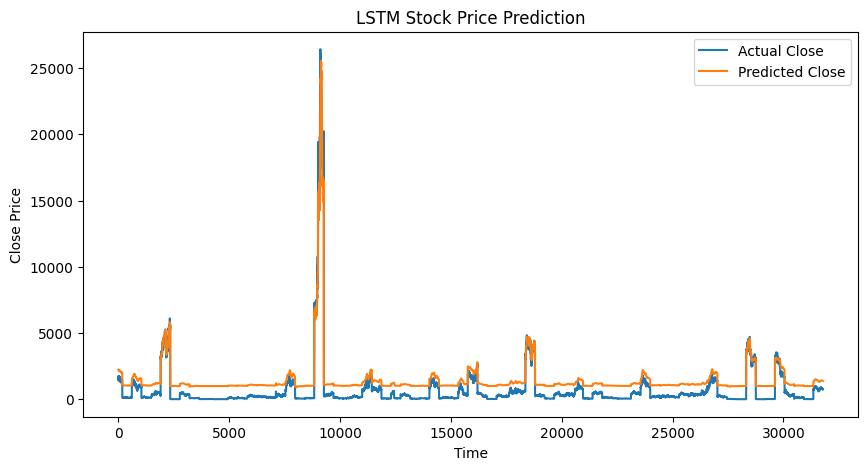

In [104]:
import matplotlib.pyplot as plt

# Predictions
y_pred = model.predict(X_test)

# Inverse scale for interpretability
close_scaler = MinMaxScaler()
close_scaler.min_, close_scaler.scale_ = scaler.min_[features.index('close')], scaler.scale_[features.index('close')]
y_test_inv = y_test / close_scaler.scale_ - close_scaler.min_ / close_scaler.scale_
y_pred_inv = y_pred / close_scaler.scale_ - close_scaler.min_ / close_scaler.scale_

# Plot actual vs predicted
plt.figure(figsize=(10,5))
plt.plot(y_test_inv, label='Actual Close')
plt.plot(y_pred_inv, label='Predicted Close')
plt.title('LSTM Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.legend()
plt.show()

In [105]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

mse = mean_squared_error(y_test_inv, y_pred_inv)
mae = mean_absolute_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_inv, y_pred_inv)

print(f"MSE : {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE : {mae:.4f}")
print(f"R²  : {r2:.4f}")

MSE : 710198.3989
RMSE: 842.7327
MAE : 801.3894
R²  : 0.8177
